# Financial Engineering - Mean Variance Portfolio Theory

###### Andrew Cachia, Dec 2018

In [22]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt  
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
from scipy.optimize import minimize
from scipy.special import ndtri

### Data
Retrieving daily closing price data for the following stocks:
- S&P500 Index [SPY]
- FTSE 100 Index [UKX]
- Gold SPDY [GLD]
- Google [GOOG]
- Amazon [AMZN]

In [23]:
ftse = pd.read_csv('Assignment/ftse-100.csv', parse_dates=True,index_col=0, date_parser=lambda x: pd.to_datetime(x).strftime("%d/%m/%Y"))
ftse = ftse['FTSE 100']
ftse.head()

Date
2017-12-29    7687.77
2017-12-28    7622.88
2017-12-27    7620.68
2017-12-22    7592.66
2017-12-21    7603.98
Name: FTSE 100, dtype: float64

In [24]:
date_start = "2014-01-01"
date_end = "2017-12-31"

symbols = ['^GSPC','GLD']

data = pd.DataFrame()
yf.pdr_override() 
data = pdr.get_data_yahoo(symbols, start=date_start, end=date_end)
data = data['Adj Close']
data['FTSE'] = ftse
data.head()

[*********************100%***********************]  2 of 2 downloaded


,GLD,^GSPC,FTSE
Date,,,
2013-12-31,116.120003,1848.359985,NaN
2014-01-02,118.000000,1831.979980,6717.91
2014-01-03,119.290001,1831.369995,6730.67
2014-01-06,119.500000,1826.770020,6730.73
2014-01-07,118.820000,1837.880005,6755.45


## Calculating logarithmic returns
We use logarithmic returns as this will allow us to assume that prices are distributed log normally. This is convenient since much of classic statistics assumes log normality. 

In [25]:
returns = data / data.shift(1)
returns = np.log(returns)
returns = returns.dropna()

##### Generic Functions

In [26]:
def mean(list):
    return list.sum() / len(list)

def generic_function(X,Y,exp):
    results = {}
    for i in X:
        sum = 0
        for j in X[i]:
            sum += (j - Y[i])**exp
        results[i] = sum / len(X[i])
    
    return results

def variance(list,mean_list):
    return generic_function(list, mean_list, 2)

##### Standard Deviation
Standard Deviation is used to describe the hisotrical volatility of an instrument. 
The greater the standard deviation, the larger the price range and fluctuations.
\begin{equation*}
\sqrt{\frac{\sum(X - \overline{X}) ^2} {N}}
\end{equation*}

In [27]:
def std_dev(list,mean_list):
    var = variance(list,mean_list)
    for i in var:
        var[i] = np.sqrt(var[i])
    return var

##### Annual Volatility

In [28]:
def annualVolatility(volatility_list):
    results = {}
    for i in volatility_list:
        results[i] = (volatility_list[i] * np.sqrt(250))# * 100
        
    return results

### Calculating Distribution Moments

In [29]:
avg_return = mean(returns)
volatility = std_dev(returns, avg_return)

annual_return = (((1 + avg_return)**250 - 1)) # * 100)
annual_volatility = annualVolatility(volatility)

I = pd.Index(["Average Return", "Volatility", "Annual Return", "Annual Volatility"])
data = [avg_return.to_dict(), volatility, annual_return.to_dict(), annual_volatility]
pd.DataFrame(data, index=I)

,FTSE,GLD,^GSPC
Average Return,0.000164,-0.000010,0.000397
Volatility,0.008867,0.008811,0.007620
Annual Return,0.041971,-0.002429,0.104328
Annual Volatility,0.140198,0.139309,0.120475


##### Covariance
Covariance is a measure of the directional relationship between the returns on two risky assets. A positive covariance means that asset returns move together while a negative covariance means returns move inversely.
\begin{equation*}
\frac{1}{N}\sum_{i=1}^N(X - \overline{X})(Y - \overline{Y})
\end{equation*}

In [30]:
def covariance(X,Y):
    meanX = mean(X)
    meanY = mean(Y)

    sum = 0

    for i in range(0, len(X)):
        sum += ((X[i] - meanX) * (Y[i] - meanY))

    return sum/(len(X)-1)

# Mean-Variance Portfolio Theory

Portfolio Variance:

$ \theta_p^2 = w_A^2\theta_A^2 + w_B^2\theta_B^2 + w_C^2\theta_C^2 + 2w_Aw_BCov_{AB} + 2w_Bw_CCov_{BC} + 2w_Aw_CCov_{AC} $

In [31]:
covarianceAB = covariance(returns['^GSPC'],returns['FTSE'])
covarianceBC = covariance(returns['FTSE'],returns['GLD'])
covarianceAC = covariance(returns['^GSPC'],returns['GLD'])

def portfolio_stats(w1,w2,w3):
    
    portfolio_return = w1*annual_return['^GSPC'] + w2*annual_return['FTSE'] + w3*annual_return['GLD']
    
    portfolio_variance = w1**2 * annual_volatility['^GSPC']**2 + w2**2 * annual_volatility['FTSE']**2 + w3**2 * annual_volatility['GLD']**2 \
        + 2*w1*w2*covarianceAB \
        + 2*w2*w3*covarianceBC \
        + 2*w1*w3*covarianceAC
    
    return portfolio_return, portfolio_variance

#### Equal Weightings

In [32]:
w1 = 1/3
w2 = 1/3
w3 = 1/3

portfolio_return, portfolio_variance  = portfolio_stats(w1,w2,w3)

print("Portfolio Return: %5.2f%%" % (portfolio_return * 100))
print("Portfolio Std Dev: %5.2f%%" % (np.sqrt(portfolio_variance) * 100))

Portfolio Return:  4.80%
Portfolio Std Dev:  7.72%


#### Simulation with 2000 different weighting combinations

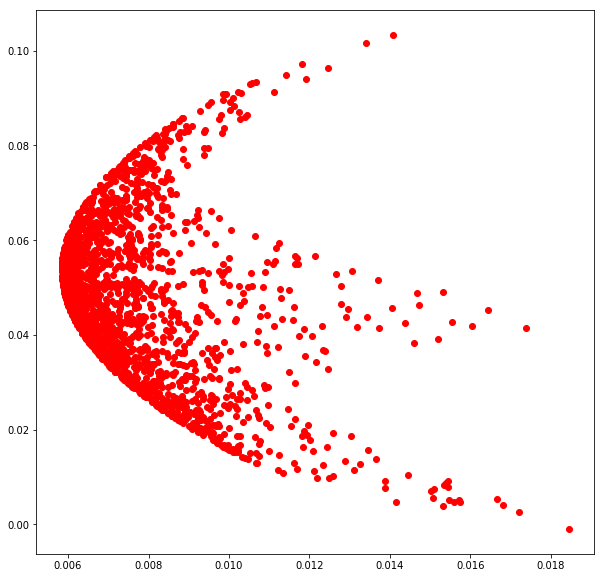

In [33]:
x = []
y = []

for i in range(0,2000):
    weights = np.random.random(3)
    weights /= np.sum(weights)
    
    portfolio_return, portfolio_variance  = portfolio_stats(weights[0],weights[1],weights[2])
    
    x.append(portfolio_variance)
    y.append(portfolio_return)
    
fig = plt.figure(figsize=(10, 10))
plt.plot(x, y, 'ro', label='Data')

In [34]:
print("Portfolio Return: %5.2f%%" % (portfolio_return * 100))

Portfolio Return:  5.50%


### Value At Risk (VaR)

The Value at Risk statistic is used to measure the amount of portfolio risk over a specific time frame. Here we are taking the 0.95 percentile. 

This means that the VaR amounts to 'x', then the portfolio has 5% chance of losing 'x' amount within the specified time frame.

In [35]:
def value_at_risk(params):
    w1,w2,w3 = params
    
    portfolio_return, portfolio_variance  = portfolio_stats(w1,w2,w3)
    
    alpha = ndtri(0.95)
    
    VaR = alpha * np.sqrt(portfolio_variance)
    
    return VaR

### Sharpe Ratio

The Sharpe Ratio is used to measure the performance of a portfolio whilst also taking into account the amount of risk exposure.

(Note that a negative sign is added to the return value since we want to determine the highest sharpe ratio - thus the minimization function will return the lowest and we invert it).

In [36]:
def sharpe_ratio(params):
    w1,w2,w3 = params
    
    portfolio_return, portfolio_variance  = portfolio_stats(w1,w2,w3)
    
    portfolio_std_dev = np.sqrt(portfolio_variance)
    
    return -portfolio_return/portfolio_std_dev

### Portfolio Optimzation

Here an optimzation library is being used to determine the optimal weights that will generate a portfolio with either the highest sharpe ratio or the lowest VaR.

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.9156022008969404
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.125716132965744
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5


Highest Sharpe Ratio
Portfolio Weights: [7.72036772e-01 2.27963228e-01 1.19262239e-18]
Sharpe Ratio: 0.9156022008969404


Lowest Value at Risk
Portfolio Weights: [0.40293468 0.29633094 0.30073438]
VaR: 0.125716132965744


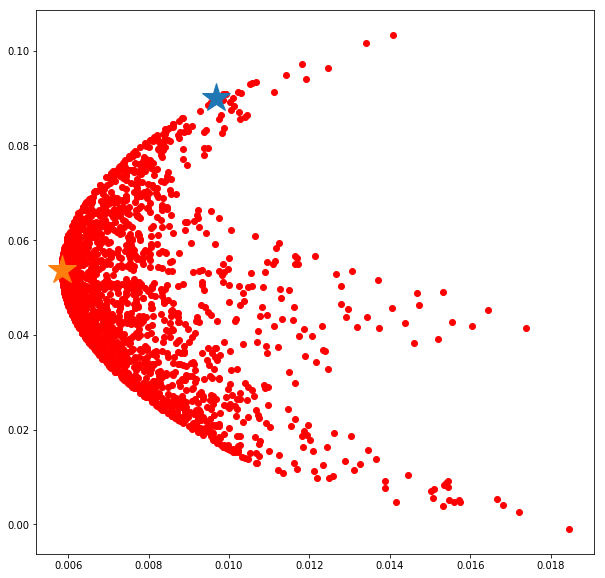

In [37]:
def apply_sum_constraint(inputs):
    total = 1 - np.sum(inputs)
    return total

my_constraints = ({'type': 'eq', "fun": apply_sum_constraint })

maxSharpeRatio = minimize(sharpe_ratio,
                   [0.5,0.2,0.3], 
                   method='SLSQP', 
                   bounds=((0,1),(0,1),(0,1)),
                   options={'disp': True},
                   constraints=my_constraints)

sr_y,sr_x = portfolio_stats(maxSharpeRatio.x[0], maxSharpeRatio.x[1],maxSharpeRatio.x[2])


minVaR = minimize(value_at_risk,
                   [0.5,0.2,0.3], 
                   method='SLSQP', 
                   bounds=((0,1),(0,1),(0,1)),
                   options={'disp': True},
                   constraints=my_constraints)

var_y, var_x = portfolio_stats(minVaR.x[0], minVaR.x[1], minVaR.x[2])

fig = plt.figure(figsize=(10, 10))
plt.plot(x, y, 'ro', label='Data')
plt.plot(sr_x, sr_y, '*', markersize=30, label='Data')
plt.plot(var_x, var_y, '*', markersize=30, label='Data')
               
               
print("\n\nHighest Sharpe Ratio")
print("Portfolio Weights: {}".format(maxSharpeRatio.x))
print("Sharpe Ratio: {}".format(-maxSharpeRatio.fun))  
               
print("\n\nLowest Value at Risk")
print("Portfolio Weights: {}".format(minVaR.x))
print("VaR: {}".format(minVaR.fun))  